## System Outside Alone

In [18]:
%matplotlib widget
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_bvp
from EOS import NeutronStarEOS
from ode_system import *
from omars_little_helpers import create_r_mesh, plot_something

ImportError: cannot import name 'plot_something' from 'omars_little_helpers' (/Users/omar/Research/Axions/pyTOVsolver/omars_little_helpers.py)

In [2]:
apr_eos = NeutronStarEOS('APR')

# BVP?

In [3]:
def outside_conditions(ya, yb):
    return np.array([
        ya[1] + a_prime_ini,                 #  ya[1] a_prime(ri) = 0
        yb[1],                 #  yb[1] a_prime(rf) = 0
        ya[2] - nu_init,    # nu(ri) = nu_initial
        ya[3] - lamb_ini, # lambda(ri) = lambda_initial
    ])

In [4]:
def ode_system(r, y):
    
    a, a_prime, nu, llambda = y

    
    # Metric Potential equation
    
    expression_for_metric_pot = -1/r + np.exp(llambda)/r  - \
                                (8 * np.exp(llambda) * fa * G * np.pi * r * (-fa * ma**2  * (-1 + np.cos(a))))/(c**4 ) + \
                                (4 * fa**2 * G * np.pi * r * a_prime**2)/c**4
    #
    dnu_dr = expression_for_metric_pot

    # Mass equation
    expression_for_mass = 1/r - np.exp(llambda)/r  + \
                          (8 * np.exp(llambda) * fa * G * np.pi * r * (-fa * ma**2  * (-1 + np.cos(a))))/(c**4) + \
                          (4 * fa**2 * G * np.pi * r * a_prime**2)/c**4
    #
    dllambda_dr = expression_for_mass

    # Klein-Gordon equation (second-order turned first-order)  
    expression_for_KG = ma**2 * np.exp(llambda) * np.sin(a) +  \
        a_prime * (-2/r + 1/2  * dllambda_dr - 1/2  * dnu_dr)
    #
    da_prime_dr = expression_for_KG



    return np.array([a_prime, da_prime_dr, dnu_dr, dllambda_dr])
#

In [12]:
# Define the domain for r
ri = 11.4e5
rf = 2e7
r = create_r_mesh(ri,rf,4000)

In [13]:
r

array([ 1140000.        ,  1144716.17904476,  1149432.35808952, ...,
       19990567.64191048, 19995283.82095524, 20000000.        ])

In [14]:
a_prime_ini = - 9.36957e-10
a_ini = -0.000139596
nu_init = 1.49796
lamb_ini = 0.459797

y_initial = np.zeros((4, r.size))  # Initialize the array with zeros
y_initial[0, :] = np.linspace(a_ini, 0, len(r))
# linearly interpolate the remaining values of a(r) from ac to final_value_a
y_initial[1, :] = np.linspace(a_prime_ini, 0, len(r))  # a_prime(r)
y_initial[2, :] = nu_init  # nu(r)
y_initial[3, :] = lamb_ini  # llambda(r)
# rho should be constant for a long distance and then decreases right before the radius

In [17]:
sol = solve_bvp(ode_system, outside_conditions, r, y_initial, verbose=2, max_nodes=1000000, tol=2.22e-14)

# Process the solution
a = sol.sol(r)[0]
a_prime = sol.sol(r)[1]
nu = sol.sol(r)[2]
llambda = sol.sol(r)[3]

# Check if the solution is successful and process it
if sol.success:
    print('Solution found!')
else:
    print("Solution was not successful.")


print(f"a(r=R) = {a[0]:0.4e}")
print(f"a'(r=R) = {a_prime[0]:0.4e}")
print(f"a(r->r_inf) = {a[-1]:0.4e}")
print(f"a'(r->r_inf) = {a_prime[-1]:0.4e}")

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.69e-13       1.28e-30         4000           2603      
       2          1.58e-14       2.55e-30         6603             0       
Solved in 2 iterations, number of nodes 6603. 
Maximum relative residual: 1.58e-14 
Maximum boundary residual: 2.55e-30
Solution found!
a(r=R) = -5.5088e-04
a'(r=R) = 9.3696e-10
a(r->r_inf) = -3.1230e-09
a'(r->r_inf) = 2.5545e-30


In [16]:
def plot_somethin(x, y, y_label, x_label=r'$r(km)$', y_scale=None, debug=False):
    plt.figure(figsize=(8, 4))
    plt.plot(x/1e5, y, color='blue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if debug:
       plt.xlim(x[-700]/1e5,x[-1]/1e5)
       plt.ylim(0,1e4)
    else:
        plt.xscale('log')
    if y_scale=='log':
        plt.yscale('log')
    plt.axvline(x=1e6/1e5, linestyle='--', color='grey', linewidth=0.4,zorder=-1)
    plt.axhline(y=0, linestyle='--', color='grey', linewidth=0.4,zorder=-1)
    
    return plt.show()

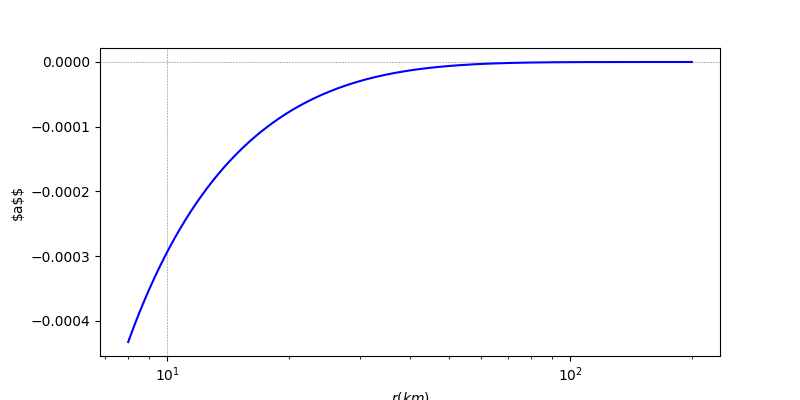

In [11]:
plt.cla()
plot_somethin(r, a, r"$a$$", x_label=r'$r(km)$')

# IVP???

In [103]:
from scipy.integrate import solve_ivp

In [124]:
initial_conditions = [a_ini, a_prime_ini, nu_init, lamb_ini]
sol = solve_ivp(ode_system, (ri,rf), initial_conditions, method='LSODA')
if sol.success:
    print('Solution found!')
    print(sol.message)
else:
    print("Solution was not successful.")
    print(sol.message)

r = sol.t
a, a_prime, nu, llambda= sol.y

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3812927947410D+08   r2 =                  NaN
Solution was not successful.
Unexpected istate in LSODA.


/var/folders/wn/k16m1d894ng_58sbvv687rhm0000gn/T/ipykernel_11796/3973075412.py:8: RuntimeWarning: overflow encountered in exp
  expression_for_metric_pot = -1/r + np.exp(llambda)/r  - \
/var/folders/wn/k16m1d894ng_58sbvv687rhm0000gn/T/ipykernel_11796/3973075412.py:9: RuntimeWarning: overflow encountered in exp
  (8 * np.exp(llambda) * fa * G * np.pi * r * (-fa * ma**2 * mu * (-1 + np.cos(a))))/(c**4 * mu) + \
/var/folders/wn/k16m1d894ng_58sbvv687rhm0000gn/T/ipykernel_11796/3973075412.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  expression_for_metric_pot = -1/r + np.exp(llambda)/r  - \
/var/folders/wn/k16m1d894ng_58sbvv687rhm0000gn/T/ipykernel_11796/3973075412.py:16: RuntimeWarning: overflow encountered in exp
  expression_for_mass = 1/r - np.exp(llambda)/r  + \
/var/folders/wn/k16m1d894ng_58sbvv687rhm0000gn/T/ipykernel_11796/3973075412.py:17: RuntimeWarning: overflow encountered in exp
  (8 * np.exp(llambda) * fa * G * np.pi * r * (-fa * ma**2 * mu * (-1 + 1)))/

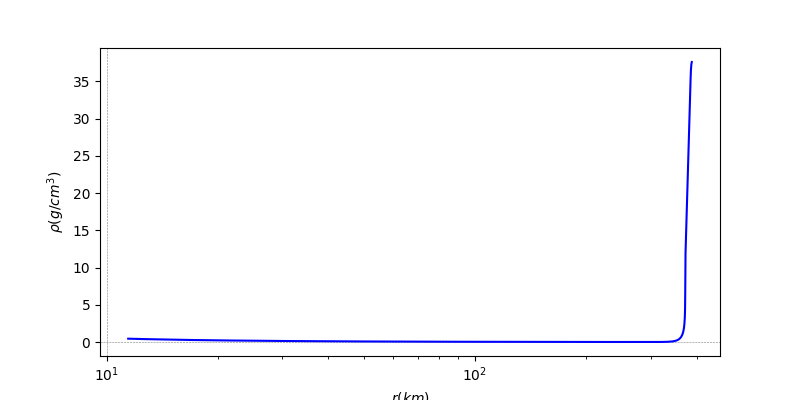

In [123]:
plot_somethin(r, llambda, r"$\rho(g/cm^{3})$", x_label=r'$r(km)$')